<a href="https://colab.research.google.com/github/glima91/mestrado-redes-neurais/blob/main/Perceptron_Multiclasse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Implemente uma Rede Neural rasa para classificação de uma base multiclasse.

Esta rede deve:

- Aceitar rótulos que podem ser números ou textos;

- Predizer os rótulos originais da base de dados;

- Passar por parâmetro no construtor:

- Função de custo e cálculo do gradiente;

- Taxa de aprendizado;

- Número máximo de iterações;

- Threshold;

- Funcionar para bases binárias.

Teste pelo menos duas funções de custo diferentes em uma base multiclasse e uma base binária.

Plote gráficos com os hiperplanos separadores encontrados pelos algoritmos de treinamento. Se a base escolhida tiver mais do que 2 características, escolha as que você julgar que fornecem a melhor visualização.


In [1]:

# Importação de bibliotecas
from sklearn.base import BaseEstimator, ClassifierMixin
import random
import numpy as np
import matplotlib.pyplot as plt

from abc import ABC, abstractmethod
from scipy.special import expit
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize

In [2]:
# Plot
def plotDataset(X, y):
  plt.xlabel('x1')
  plt.ylabel('x2')
  for k in set(y):
      plt.plot(X[:,0][y==k],
                X[:,1][y==k],
                "o", alpha=0.3)
      
def plotHiperplano(vetor, bias=0, xmin=0, xmax=1):
    xs = np.linspace(xmin, xmax, num=2)
    ys = (-vetor[0] / vetor[1]) * xs - bias / vetor[1]
    plt.plot(xs,ys)


def plotCost(cost):  
  x_l = list(range(1, len(cost)+1))

  plt.figure(figsize=(20,5))
  plt.plot(x_l, cost,"-")
  #plt.xticks(x_l)
  plt.title("Perceptron")
  plt.xlabel('Num. da Iteração')
  plt.ylabel('Custo')
  plt.show()

In [16]:
# Classes abstratas
class TrainingAlgorithm(ABC):
  @abstractmethod
  def getW(self,X,y):
    pass

class PseudoInversa(TrainingAlgorithm):
  def getW(self, X,y):
    print(np.linalg.pinv(X) @ y)
    return np.linalg.pinv(X) @ y

# Funcoes de custo
class Custo(ABC):
  @abstractmethod
  def custo(y, ypred):
    pass
  @abstractmethod
  def gradiente(y, ypred):
    pass

class WidrowHoff(Custo):
  @staticmethod
  def custo(y, ypred):
    return np.sum((y - ypred) ** 2)
  @staticmethod
  def gradiente(y, ypred):
    return y- ypred
  
class SmoothedSurrogate(Custo):
  @staticmethod
  def gradiente(y, ypred):
    return y - sign(ypred)

  @staticmethod
  def custo(y, ypred):
    return np.sum(np.maximum(np.zeros(y.shape), -y * ypred))

class LogLikehood(Custo):
  @staticmethod
  def gradiente(y, ypred):
    return y - (expit(ypred)*2 - 1)

  @staticmethod
  def custo(y, ypred):
    return np.sum(np.log(1+np.exp(-y * ypred)))

class HingeLoss(Custo):
  @staticmethod
  def custo(y, ypred):
    return np.sum(np.maximum(np.zeros(y.shape), 1 - y*ypred))
  
  @staticmethod
  def gradiente(y, ypred):
    errosmarginais = (y * ypred) < 1
    ymarginais = np.copy(y)
    ymarginais[~errosmarginais] = 0
    return ymarginais

In [109]:
# Otimização por gradiente descendente
class DescidaGradiente(TrainingAlgorithm):
  def __init__(self, max_iter=1000, learning_rate=0.001, regularization=0, cost=WidrowHoff()):
    self.max_iter = max_iter
    self.learning_rate = learning_rate
    self.regularization = regularization
    self.cost = cost
    self.cost_batch = []

  def getW(self,X,y):
    w = np.random.uniform(-1,1,size=(X.shape[1],y.shape[1]))
    for j in range(self.max_iter):
      ypred = X @ w

      custo = self.cost.custo(y,ypred)
      self.cost_batch.append(custo)
      if custo ==0:
        break
      w *= 1 - self.learning_rate*self.regularization
      w += (X.T @ self.cost.gradiente(y,ypred)) * self.learning_rate
    return w



# Perceptron multiclasse

def sign(a):
  return (a>=0) * 2 - 1

def accuracy(yactual, ypred):
  return sum(yactual == ypred)/len(yactual)

class Perceptron(ClassifierMixin,BaseEstimator):
  def __init__(self,training_algorithm=DescidaGradiente(), max_iter=1000, activation=sign):
    self.w = None
    self.max_iter=max_iter
    self.activation = activation
    self.training_algorithm = training_algorithm
  
  def fit(self,X,y):
    yhot = self.encode_labels(y)
    Xb = Perceptron.includeBias(X)
    self.w = self.training_algorithm.getW(Xb,yhot)

  def predict(self,X,y=None):
    Xb = Perceptron.includeBias(X)
    a = Xb @ self.w
    ypred = self.activation(a)
    if self.w.shape[1] == 1:
      idx = np.array(a>0,dtype=int).reshape(-1)
    else:
      idx = np.argmax(a,axis=1)
    ypred = np.array([self.labels[i] for i in idx])
    return ypred

  def encode_labels(self,y):
    self.labels = list(set(y))
    return label_binarize(y,classes=self.labels)*2 -1

  @staticmethod
  def includeBias(X):
    bias = np.ones((X.shape[0],1))
    Xb = np.concatenate((bias,X),axis=1)
    return Xb 

In [110]:
# Cria datasets
def criaDatasetBinario(n=200,slop=[2,1],intercept=-0.4):
  X = np.random.uniform(size=(n,2))
  AUX = np.multiply(X,slop) - [0,intercept]
  y = (AUX[:,0] > AUX[:,1])*2 -1
  return X, y

def criaDatasetBlobs(n=1000,n_classes=4,std=0.05):
  X,y = make_blobs(n_samples=n,centers=n_classes,center_box=(0,1.0),cluster_std=std)
  return X,y

def criaDatasetXOR(n=100):
  X,y = make_blobs(n_samples=n,centers=[[0,0],[1,0],[1,1],[0,1]],cluster_std=0.1)
  y =np.array(y%2,dtype=int)
  return X,y

In [111]:
#X, y = criaDatasetBlobs()
X, y = criaDatasetBinario(n=200)
#X,y = criaDatasetXor()

Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=.9)

In [112]:
ytr

array([-1, -1,  1, -1, -1, -1,  1, -1, -1, -1,  1, -1,  1,  1, -1,  1, -1,
       -1,  1, -1])

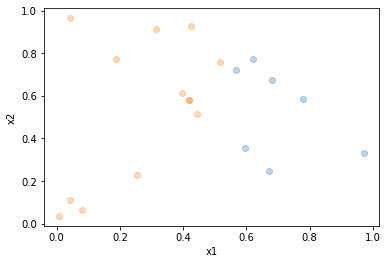

In [113]:
# Plotagem de dois atributos da base de dados
plotDataset(Xtr, ytr)

In [114]:
# Criacao do modelo
perceptron = Perceptron(DescidaGradiente(learning_rate=0.01,max_iter=10000,cost=HingeLoss()))
perceptron.fit(Xtr,ytr)

In [115]:
# Avaliacao do modelo para o conjunto de treino
ypred = perceptron.predict(Xtr,ytr)
print("Train Acuracy: ", sum(ytr == ypred)/len(ytr))

Train Acuracy:  1.0


In [116]:
# Avaliacao do modelo para o conjunto de teste
ypred = perceptron.predict(Xte,yte)
print("Test Acuracy: ", sum(yte== ypred)/len(yte))

Test Acuracy:  0.95


[[  6.47255623]
 [-16.01446828]
 [  3.21411447]]


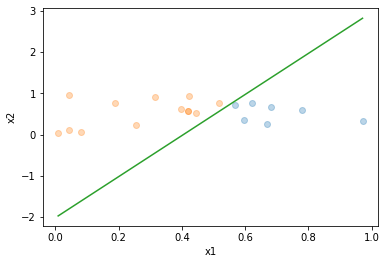

In [117]:
# Plotagem do hiperplano
plotDataset(Xtr, ytr)

print(perceptron.w)


plotHiperplano(perceptron.w[1:,0], perceptron.w[0,0], min(Xtr[:,0]), max(Xtr[:,0]))

In [118]:
# Matriz com pesos
perceptron.w

array([[  6.47255623],
       [-16.01446828],
       [  3.21411447]])

## Experimentos

### Dataset 1 (tipo binário)

In [119]:
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler

data = load_breast_cancer()
X = StandardScaler().fit_transform(data['data'])
y = data['target']

Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=.2)

Xtr

array([[-6.60983893e-01, -6.30553396e-01, -5.34608984e-01, ...,
         1.09469759e+00,  4.64827890e+00,  1.05590311e+00],
       [-2.52003450e-01,  1.95555434e-01, -2.10030206e-01, ...,
         3.21186447e-01, -9.02005095e-02,  2.26950952e+00],
       [ 6.00039138e-01, -1.20925696e-01,  6.93270885e-01, ...,
         8.92183849e-01, -2.11534055e-01,  1.23877531e+00],
       ...,
       [-9.84760076e-01, -9.63323995e-01, -1.00829629e+00, ...,
        -1.74506282e+00, -3.08600892e-01, -1.23609510e+00],
       [-4.84895091e-01, -9.88921734e-01, -5.50261260e-01, ...,
        -1.12808109e+00,  3.95204754e-04, -8.93071186e-01],
       [ 4.62114557e-02, -5.74703785e-01, -6.87478196e-02, ...,
        -1.23756033e+00, -7.16281606e-01, -1.26047806e+00]])

**Hinge loss**

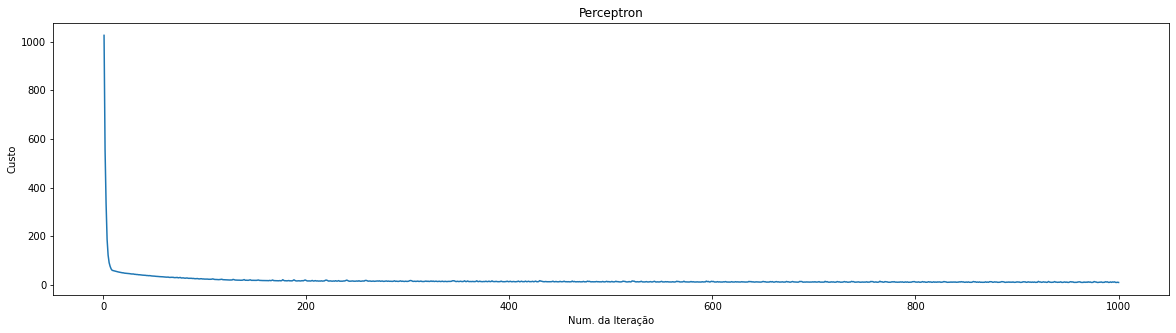


Train Acuracy:  0.9934065934065934
Test Acuracy:  0.956140350877193


In [122]:
# Criacao do modelo
perceptron = Perceptron(DescidaGradiente(max_iter=1000, learning_rate=0.01,cost=HingeLoss()))
perceptron.fit(Xtr,ytr)

cost = perceptron.training_algorithm.cost_batch
#print(cost)
plotCost(cost)

# Avaliacao do modelo para o conjunto de treino
ypred = perceptron.predict(Xtr,ytr)
print("\nTrain Acuracy: ", sum(ytr == ypred)/len(ytr))

# Avaliacao do modelo para o conjunto de teste
ypred = perceptron.predict(Xte,yte)
print("Test Acuracy: ", sum(yte== ypred)/len(yte))

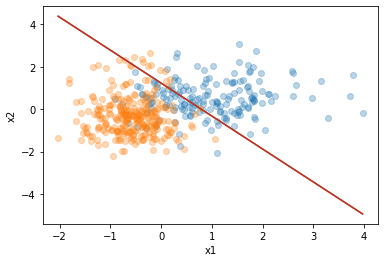

In [123]:
# Plotagem do hiperplano
plotDataset(Xtr, ytr)
# print(set(ytr))
# print(perceptron.w[1:], perceptron.w[0])
for i in range(len(set(ytr))):
  plotHiperplano(perceptron.w[1:], perceptron.w[0], min(X[:,0]), max(X[:,0]))

**Smoothed Surrogate**

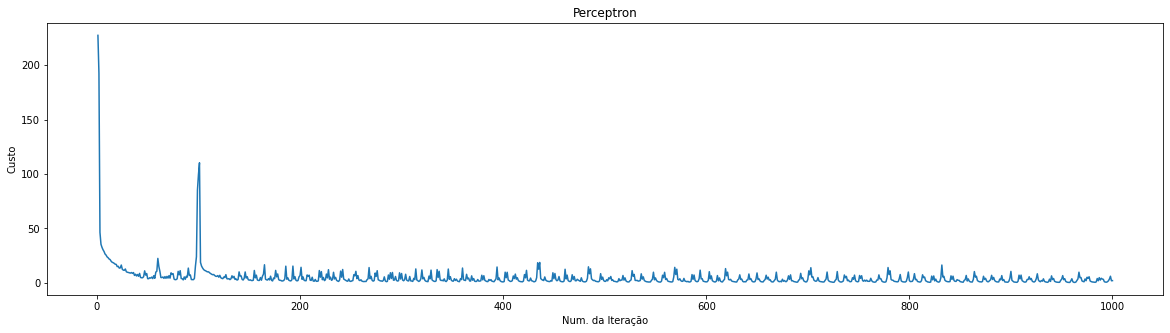


Train Acuracy:  0.989010989010989
Test Acuracy:  0.956140350877193


In [124]:
# Criacao do modelo
perceptron = Perceptron(DescidaGradiente(max_iter=1000, learning_rate=0.01,cost=SmoothedSurrogate()))
perceptron.fit(Xtr,ytr)

cost = perceptron.training_algorithm.cost_batch
plotCost(cost)

# Avaliacao do modelo para o conjunto de treino
ypred = perceptron.predict(Xtr,ytr)
print("\nTrain Acuracy: ", sum(ytr == ypred)/len(ytr))

# Avaliacao do modelo para o conjunto de teste
ypred = perceptron.predict(Xte,yte)
print("Test Acuracy: ", sum(yte== ypred)/len(yte))

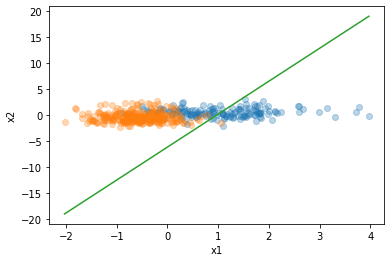

In [125]:
# Plotagem do hiperplano
plotDataset(Xtr, ytr)

for i in range(perceptron.w.shape[1]):
  plotHiperplano(perceptron.w[1:,i], perceptron.w[0,i], min(X[:,0]), max(X[:,0]))

### Dataset 2 (tipo  multiclasse)

In [126]:
from sklearn.datasets import load_iris
data = load_iris()
X = StandardScaler().fit_transform(data['data'])
y = data['target']

Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=.2)

**Hinge loss**

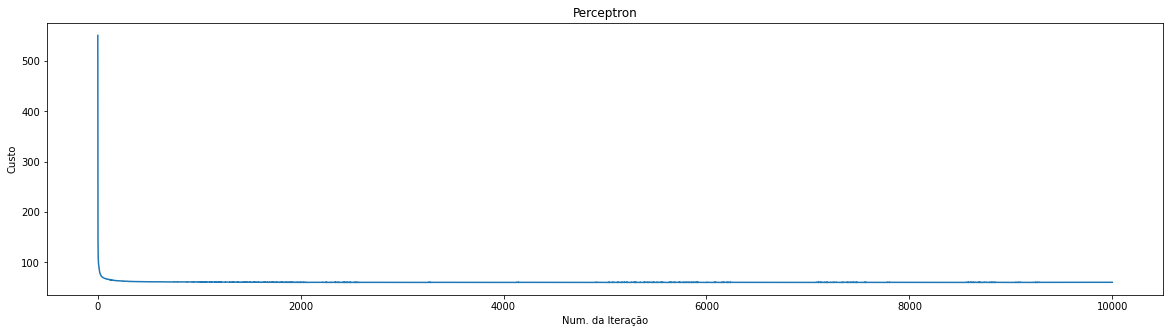


Train Acuracy:  0.975
Test Acuracy:  0.8666666666666667


In [127]:
# Criacao do modelo
perceptron = Perceptron(DescidaGradiente(max_iter=10000, learning_rate=0.01,cost=HingeLoss()))
perceptron.fit(Xtr,ytr)

cost = perceptron.training_algorithm.cost_batch
plotCost(cost)

# Avaliacao do modelo para o conjunto de treino
ypred = perceptron.predict(Xtr,ytr)
print("\nTrain Acuracy: ", sum(ytr == ypred)/len(ytr))

# Avaliacao do modelo para o conjunto de teste
ypred = perceptron.predict(Xte,yte)
print("Test Acuracy: ", sum(yte== ypred)/len(yte))

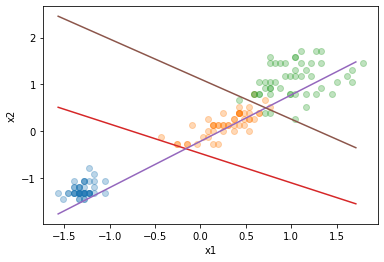

In [135]:
# Plotagem do hiperplano
plotDataset(X[:,[2,3]], y)

for i in range(perceptron.w.shape[1]):
  plotHiperplano(perceptron.w[3:,i], perceptron.w[0,i], min(Xtr[:,2]), max(Xtr[:,3]))

**LogLikehood**

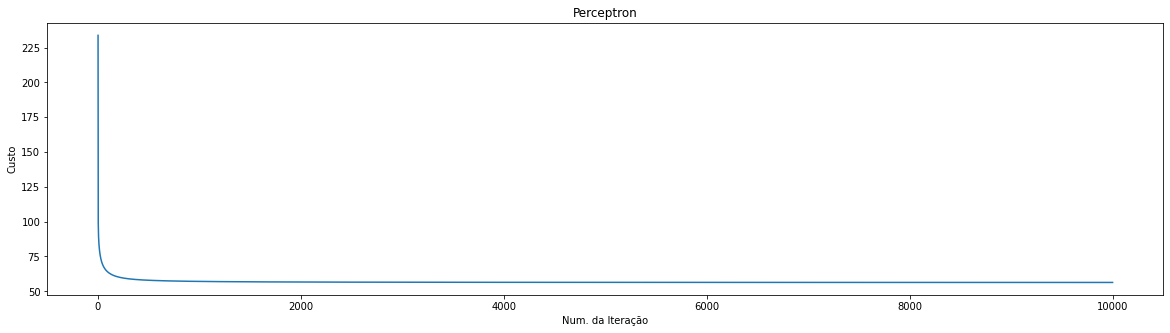


Train Acuracy:  0.9666666666666667
Test Acuracy:  0.9


In [136]:
# Criacao do modelo
perceptron = Perceptron(DescidaGradiente(max_iter=10000, learning_rate=0.01,cost=LogLikehood()))
perceptron.fit(Xtr,ytr)

cost = perceptron.training_algorithm.cost_batch
plotCost(cost)

# Avaliacao do modelo para o conjunto de treino
ypred = perceptron.predict(Xtr,ytr)
print("\nTrain Acuracy: ", sum(ytr == ypred)/len(ytr))

# Avaliacao do modelo para o conjunto de teste
ypred = perceptron.predict(Xte,yte)
print("Test Acuracy: ", sum(yte== ypred)/len(yte))

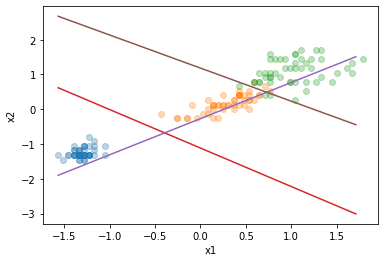

In [138]:
# Plotagem do hiperplano
plotDataset(X[:,[2,3]], y)

for i in range(perceptron.w.shape[1]):
  plotHiperplano(perceptron.w[3:,i], perceptron.w[0,i], min(Xtr[:,2]), max(Xtr[:,3]))